<h4>Note: Just replace Lululemon and Lulu with the brand you are analyzing, those values are hardcoded in the content cleanup part

In [8]:
import datetime

import gensim
import nltk
import pandas as pd
from gensim.utils import simple_preprocess
from langdetect import detect
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer
from PIL import Image
from textblob import TextBlob
from wordcloud import STOPWORDS, WordCloud

nltk.download('stopwords')
import pickle

import pyLDAvis
import pyLDAvis.gensim_models
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vitaliipoiarkov/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<h3>Read previously saved CSV

In [1]:
filename = "Lulu_tweets_w_sentiment_en.csv"
df = pd.read_csv(filename, index_col='id', low_memory = False)
#convert datatypes
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = pd.to_datetime(df['date'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
df.head()

,timestamp,content,username,date,clean_content,lang,neg,neu,pos,compound,sentiment,polarity,subjectivity
id,,,,,,,,,,,,,
1042563491851390977,2018-09-19 23:58:01+00:00,Hey @lululemonCHI @lululemon I stopped at your...,jleboyer,2018-09-19,Hey I stopped at your running station in Chica...,en,0.105,0.788,0.108,0.2734,positive,0.5,0.625
1042563239786229760,2018-09-19 23:57:00+00:00,@ahmedtheelder You know what that means:https:...,lululemon,2018-09-19,You know what that meanshttpstcoiTRlSZik7d,en,0.000,1.000,0.000,0.0000,neutral,0.0,0.000
1042560954431623169,2018-09-19 23:47:56+00:00,@_danalouise MFM???? One of my favorite episod...,pjscaggs,2018-09-19,MFM One of my favorite episodes Lululemon is s...,en,0.000,0.750,0.250,0.4588,positive,0.5,1.000
1042559817691394048,2018-09-19 23:43:25+00:00,"PRESS RELEASE: Burglary and Grand Theft; ""Grab...",SantaRosaPolice,2018-09-19,PRESS RELEASE Burglary and Grand Theft Grab an...,en,0.000,0.812,0.188,0.4588,positive,0.5,1.000
1042558723854663680,2018-09-19 23:39:04+00:00,Ready for #SeaWheeze this weekend!\n•\n•\n•\n#...,shiftwitz,2018-09-19,Ready for SeaWheeze this weekend vancouver can...,en,0.000,0.828,0.172,0.3612,positive,0.1,0.250


<h3>Wordcloud

In [16]:
#remove amp from content (bad formatting, didn't remove some special chars)
stop_words = ['amp', 'lululemon', 'lulu']
f = lambda x: ' '.join(w for w in x.split() if not w.lower() in stop_words)
df['clean_content'] = df['clean_content'].apply(f)

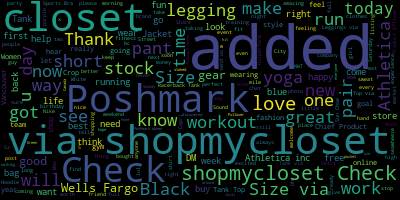

In [17]:
wordcloud_lulu = WordCloud().generate(' '.join(df['clean_content']))
wordcloud_lulu.to_image()

<h3>Topic modelling

In [18]:
stop_words = stopwords.words('english') 
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
df_work = df.copy(deep=True)

def sent_to_words(sentences): 
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [19]:
data = df_work.clean_content.values.tolist() 
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

['hey', 'stopped', 'running', 'station', 'chicago', 'lake', 'shore', 'trail', 'able', 'work', 'machine', 'allow', 'answer', 'questions', 'help']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]


In [20]:
#LDA model training
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"via" + 0.010*"check" + 0.010*"shopmycloset" + 0.010*"poshmark" + '
  '0.010*"added" + 0.009*"love" + 0.009*"got" + 0.009*"closet" + 0.008*"us" + '
  '0.006*"athletica"'),
 (1,
  '0.041*"via" + 0.040*"poshmark" + 0.040*"check" + 0.038*"added" + '
  '0.038*"shopmycloset" + 0.037*"closet" + 0.017*"size" + 0.009*"tank" + '
  '0.006*"leggings" + 0.006*"like"'),
 (2,
  '0.011*"via" + 0.011*"check" + 0.010*"yoga" + 0.008*"like" + 0.006*"new" + '
  '0.006*"know" + 0.006*"pants" + 0.006*"size" + 0.006*"great" + '
  '0.006*"shopmycloset"'),
 (3,
  '0.010*"check" + 0.009*"via" + 0.008*"poshmark" + 0.007*"size" + '
  '0.007*"athletica" + 0.006*"shopmycloset" + 0.006*"closet" + 0.006*"added" + '
  '0.005*"us" + 0.005*"tank"'),
 (4,
  '0.013*"like" + 0.009*"love" + 0.009*"athletica" + 0.005*"best" + '
  '0.005*"blue" + 0.005*"workout" + 0.005*"new" + 0.004*"inc" + 0.004*"send" + '
  '0.004*"way"'),
 (5,
  '0.036*"via" + 0.033*"check" + 0.032*"poshmark" + 0.032*"shopmycloset" + '
  '0.

In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = 'Lulu_10_topics.html'
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, LDAvis_data_filepath)
#LDAvis_prepared

/opt/homebrew/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
